In [104]:
import os
import pickle
from glob import glob
from tqdm.notebook import tqdm

from PIL import Image

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall

from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu as mnu
from scipy.stats import permutation_test
from math import log10

from scipy.ndimage import gaussian_filter as smooth

import torch
import torchvision.models as MODELS
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torchvision import transforms

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

# Definitions

In [105]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in input_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat


def mk_repmat_mdl(net_resp, stim_idx=[]):
    '''
    Args:
        net_resp: ---
        stim_idx: ---
    Returns:
        (M,N,N) representatational matrices of the model layers, where M is the number of layers and
        N is the total number of samples
    '''

    if not list(stim_idx): stim_idx=np.arange(0,net_resp[list(net_resp.keys())[0]].shape[0])

    mdl_repmat = []
    for layer in net_resp.keys():
        layer_resp = net_resp[layer][stim_idx,:].T
        mdl_repmat.append(mk_repmat_data(layer_resp))

    return np.array(mdl_repmat)


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=plot_sz*2)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*5)
    plt.tight_layout()


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def m_plot_net(all_models, color=[129, 104, 157, 80], labels=[], sub_titles=[], plot_title='', figure_size=(8,3)):
    '''
    Args:
        all_models:  (N,M) matrix of input data, (Repetitions,Layers)
        color:       color for the generated in [R,G,B,FaceAlpha] format. FaceAlpha in the scale=[0-255]
        label:       label for the generated line
        plot_title:  title of the generated plot
        figure_size: (width,height) of the figure
        sub_titles:  title for every subplot
    Returns:
        none
    '''
    if not labels: labels=['']*len(all_models)
    if not sub_titles: sub_titles=['']*len(all_models)
    color = np.array(color) / np.array(255)

    fig, axs = plt.subplots(nrows=1, ncols=len(all_models), figsize=figure_size, sharey=True)
    
    for ax,model,label,title in zip(axs, all_models, labels, sub_titles):
        
        layers = np.arange(1,model.shape[1]+1)

        data_ave = np.nanmean(model, axis=0)
        data_std = np.nanstd(model, axis=0)

        ax.fill_between(layers, data_ave+data_std, data_ave-data_std, color=color, label='_nolegend_')
        ax.plot(layers, data_ave, color=color[:3], lw=3, label=label)
        # ax.plot(layers, data_ave, marker='.', markersize=20, color=color[:3], lw=3, label=label)

        ax.set_xlim([min(layers),max(layers)])
        # ax.set_xticks(layers)
        ax.set_xticks([min(layers), max(layers)])
        
        ax.set_xlabel('Layer')
        ax.set_title(title)
        # ax.legend(frameon=False, fontsize=10)
    
    axs[0].set_ylabel('Similarity (au)')
    axs[0].set_yticks(np.array(plt.ylim()).round(1))
    fig.suptitle(plot_title, fontsize=figure_size[1]*5)
    plt.tight_layout()


def compute_similarity(data_mat, kernel_mat, sim_method='kendall'):
    '''
    Args:
        data_mat:   (N,N) representatational matrix created from data,
                    where N is the number of conditions
        kernel_mat: (N,N) theoretical ground-truth representatational matrix,
                    where N is the number of conditions
        sim_method: method to calculate similarity
    Returns:
        similarity: similarity value between data_mat and kernel_mat
    '''
    if sim_method!='kendall':
        data_mat = data_mat.reshape((data_mat.shape[0]**2,1))
        kernel_mat = kernel_mat.reshape((kernel_mat.shape[0]**2,1))

    if sim_method=='kendall':
        similarity = kendall(data_mat, kernel_mat)[0]
    elif sim_method=='spearman':
        similarity = spearman(data_mat, kernel_mat)[0]
    elif sim_method=='pearson':
        similarity = pearson(data_mat, kernel_mat)[0]

    return similarity


def compute_rsa(data_input, conds_ls=[], sp_kernel=[], sim_method='kendall', print_info=False):
    '''
    Args:
        data_input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        conds_ls:   list with the number of samples per condition, i.e., the list size is the number
                    of categories, and each item is the number of stimuli per that category
        sp_kernel:  (N,N) representatational matrix, i.e., specific kernel,
                    where N is the number of stimuli
        sim_method: method to calculate similarity
        print_info: if True, the progression will be printed
    Returns:
        rsa: (N,) vector of similarity values, where N is the number of timepoints
    '''
    
    if not list(sp_kernel): kernel = mk_repmat_kernel(conds_ls)
    elif not list(conds_ls): kernel = sp_kernel

    rsa = []
    for i_time in range(data_input.shape[2]):
        temp_mat = []
        temp_mat = mk_repmat_data(data_input[:,:,i_time])
        rsa.append(compute_similarity(temp_mat, kernel, sim_method))

        if print_info:
            print('% ' + str(((i_time+1)/data_input.shape[2])*100))
            
    return np.array(rsa)


def repmat_extremizer(input_repmat, szs_ls, coeffs=[1,1], clip_vals=[0,1]):
    '''
    Args:
        input_repmat: (N,N) representatational matrix, where N is the total number of stimuli
        szs_ls:       (N,) list with the number of samples per condition, i.e., 
                      the list size is the number of categories
        coeffs:       (2,) list of coefficients to scale the "input_repmat"; members of the same category
                      will be scaled by coeffs[0], and members of different categories will be scaled by
                      coeffs[1]
        clip_vals:    (2,) list of minimum (clip_vals[0]) and maximum (clip_vals[1]) acceptable values for
                      representatational matrix
    Returns:
        trans_repmat: (N,N) transformed representatational matrix, where N is the total number of stimuli
    '''

    coeffs = np.sort(coeffs)
    clip_vals = np.sort(clip_vals)
    coeff_mat = np.array(coeffs[0]) * np.ones([input_repmat.shape[0],input_repmat.shape[1]])
    counter_ind = 0
    for i in szs_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        coeff_mat[np.ix_(inds,inds)] = coeffs[1]
    trans_repmat = input_repmat * coeff_mat
    trans_repmat[trans_repmat<clip_vals[0]] = clip_vals[0]
    trans_repmat[trans_repmat>clip_vals[1]] = clip_vals[1]

    return trans_repmat


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def mdl_evaluator(mdl, net_layers, img_names, mdl_name, file_dir):
    '''
    Args:
        mdl: 
        req_layers: 
        mdl_name: 
        file_dir: 
    Returns:
        none
    '''

    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
    
    mdl.eval()
    fex = create_feature_extractor(mdl, return_nodes=net_layers)
    NetResp = {}

    with torch.no_grad():
        for im_name in tqdm(img_names):
            img = Image.open(im_name).convert('RGB')

            out = fex(transform(img).unsqueeze(0))
            for layer in out.keys():
                rep = out[layer].cpu().detach().numpy().flatten()
                if layer not in NetResp.keys():
                    NetResp[layer] = []
                NetResp[layer].append(rep)

    for key in NetResp.keys():
        NetResp[key] = np.array(NetResp[key])
    
    with open(f'{file_dir}{mdl_name}-netresp.pkl', 'wb') as f:
        pickle.dump(NetResp, f)


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)
    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_permute_p(vec1, vec2, tailed='two-sided', permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        tailed:       The alternative hypothesis for which the p-value is calculated
                      'greater':   the percentage of the null distribution that is greater than or equal to the observed value of the test statistic
                      'less':      the percentage of the null distribution that is less than or equal to the observed value of the test statistic
                      'two-sided': twice the smaller of the p-values above
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: p-value of the permutation process for [vec2 - vec1]
    '''

    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, alternative=tailed, random_state=15, n_resamples=permute_reps).pvalue

    return p_val



# Stimuli

In [106]:
FigDir = '../Results/figs_nn/'
FilesDir= 'nn_files/'

stimset_path = '../utils/StimSet'
img_names = sorted(glob(os.path.join(stimset_path, '*.*')))
# print(len(img_names))
# print(img_names[0])

stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

# color
diff_color = np.array((250, 112, 112))/255
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80
cycle_num = 200

abs_level = 1
if abs_level == 1:
    myCond = 'Animacy'
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
elif abs_level == 2:
    myCond = 'FaceBody'
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
ind_all = np.concatenate((indc1, indc2), axis=0)

# sub-sampling
cat_inds = [indc1,indc2]
idx_rand = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)
FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

resp_itc, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Neural Netwroks

In [ ]:
mdl_name = 'alexnet'
mdl = MODELS.alexnet(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    # node_name: user-specified key for output dict
    'features.1':  'layer2',
    'features.4':  'layer3',
    'features.7':  'layer4',
    'features.9':  'layer5',
    'features.12': 'layer6'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'squeezenet'
mdl = MODELS.squeezenet1_1(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.0':  'layer1',
    'features.1': 'layer2',
    'features.2': 'layer3',
    'features.3.cat': 'layer4',
    'features.4.cat': 'layer5',
    'features.5': 'layer6',
    'features.6.cat': 'layer7',
    'features.7.cat': 'layer8',
    'features.8': 'layer9',
    'features.9.cat': 'layer10',
    'features.10.cat': 'layer11',
    'features.11.cat': 'layer12',
    'features.12.cat': 'layer13'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'resnet50'
mdl = MODELS.resnet50(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'layer1.2.relu_2': 'layer1',
    'layer2.3.relu_2': 'layer2',
    'layer3.5.relu_2': 'layer3',
    'layer4.2.relu_2': 'layer4',
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'densenet'
mdl = MODELS.densenet201(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.transition1.pool':  'layer1',
    'features.transition2.pool':  'layer2',
    'features.transition3.pool': 'layer3',
    'flatten': 'layer4',
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'inception'
mdl = MODELS.inception_v3(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'maxpool1': 'layer2',
    'maxpool2': 'layer3',
    'Mixed_5d.cat': 'layer4',
    'Mixed_6e.cat': 'layer5',
    'avgpool': 'layer6'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'EfficientNet'
mdl = MODELS.efficientnet_b1(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.1.1.add': 'layer1',
    'features.2.2.add': 'layer2',
    'features.3.2.add': 'layer3',
    'features.4.3.add': 'layer4',
    'features.5.3.add': 'layer5',
    'features.6.4.add': 'layer6',
    'features.7.1.add': 'layer7',
    'avgpool': 'layer8'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\user.JAJLAB2/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:22<00:00, 1.44MB/s]


  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'vgg16'
mdl = MODELS.vgg16(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.4':  'layer1',
    'features.9':  'layer2',
    'features.16': 'layer3',
    'features.23': 'layer4',
    'features.30': 'layer5'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user.JAJLAB2/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [07:06<00:00, 1.30MB/s] 


  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'vgg19'
mdl = MODELS.vgg19(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.4':  'layer1',
    'features.9':  'layer2',
    'features.18': 'layer3',
    'features.27': 'layer4',
    'features.36': 'layer5'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\user.JAJLAB2/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [07:19<00:00, 1.31MB/s] 


  0%|          | 0/335 [00:00<?, ?it/s]

In [ ]:
mdl_name = 'MobileNet'
mdl = MODELS.mobilenet_v3_large(pretrained=True, progress=True)

# train_nodes, eval_nodes = get_graph_node_names(mdl)

req_layers = {
    'features.0':  'layer1',
    'features.1.add': 'layer2',
    'features.2.block.2': 'layer3',
    'features.3.add': 'layer4',
    'features.4.block.3': 'layer5',
    'features.5.add': 'layer6',
    'features.6.add': 'layer7',
    'features.7.block.2': 'layer8',
    'features.8.add': 'layer9',
    'features.9.add': 'layer10',
    'features.10.add': 'layer11',
    'features.11.block.3': 'layer12',
    'features.12.add': 'layer13',
    'features.13.block.3': 'layer13',
    'features.14.add': 'layer14',
    'features.15.add': 'layer15',
    'features.16': 'layer16'
}

mdl_evaluator(mdl, net_layers=req_layers, img_names=img_names, mdl_name=mdl_name, file_dir=FilesDir)

  0%|          | 0/335 [00:00<?, ?it/s]

# Vis -> Plot

  0%|          | 0/9 [00:00<?, ?it/s]

(0.0, 0.7)

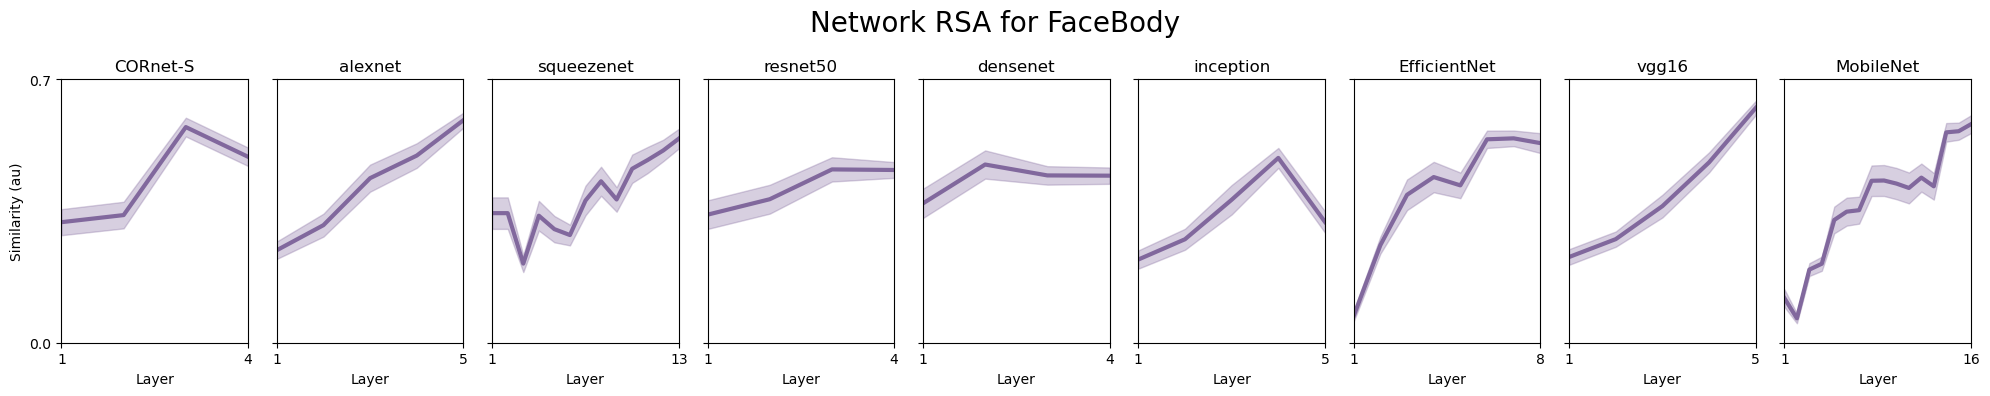

In [5]:
all_models = ['CORnet-S', 'alexnet', 'squeezenet', 'resnet50', 'densenet', 'inception', 'EfficientNet', 'vgg16', 'MobileNet']
fig_sz = np.array((5,1)) * 4

all_model_rsa = []
for model in tqdm(all_models):
        with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
                mdl_rep = mk_repmat_mdl(pickle.load(f))
        
        mdl_rsa = []
        for iCycle in range(cycle_num):
                cycle_sim = []
                for rep in mdl_rep:
                        cycle_sim.append(compute_similarity((rep[idx_rand[iCycle]].T)[idx_rand[iCycle]], 
                                                            mk_repmat_kernel([stim_num,stim_num])))
                mdl_rsa.append(cycle_sim)
        all_model_rsa.append(np.array(mdl_rsa))

m_plot_net(all_model_rsa, sub_titles=all_models, figure_size=fig_sz, plot_title=f'Network RSA for {myCond}')
plt.ylim([.0,.7])

# plt.savefig(f'{FigDir}nn_sim_{myCond}.svg')


In [103]:
all_mdl_slopes = np.zeros(len(all_models)) * np.nan
all_mdl_r, all_mdl_pval, all_mdl_se, all_mdl_r2 = np.copy(all_mdl_slopes), np.copy(all_mdl_slopes), np.copy(all_mdl_slopes), np.copy(all_mdl_slopes)

for imdl,mdl in enumerate(all_model_rsa):
    tmp_corr_mat_x, tmp_corr_mat_y = np.array(()), np.array(())
    for ilayer,layer in enumerate(mdl.T):
        tmp_corr_mat_x = np.concatenate((tmp_corr_mat_x, np.ones_like(layer)*ilayer), axis=0)
        tmp_corr_mat_y = np.concatenate((tmp_corr_mat_y, layer), axis=0)
    all_mdl_slopes[imdl], _, all_mdl_r[imdl], all_mdl_pval[imdl], all_mdl_se[[imdl]] = linregress(tmp_corr_mat_x, tmp_corr_mat_y)
    all_mdl_r2[imdl] = all_mdl_r[imdl]**2

    print(f'{all_models[imdl]} =>   r2: {all_mdl_r2[imdl]} | p-val: {all_mdl_pval[imdl]} | se: {all_mdl_se[imdl]}')


CORnet-S =>   r2: 0.5880207348716306 | p-val: 7.961498136162121e-156 | se: 0.00223808060496693
alexnet =>   r2: 0.9389812926423631 | p-val: 0.0 | se: 0.000707124757371005
squeezenet =>   r2: 0.6224550454390556 | p-val: 0.0 | se: 0.0003188012789101142
resnet50 =>   r2: 0.6306467805101155 | p-val: 9.118130087445989e-175 | se: 0.001179924045511823
densenet =>   r2: 0.1878188124071827 | p-val: 5.7960711485949e-38 | se: 0.0014149380375635824
inception =>   r2: 0.363990672238984 | p-val: 3.5419657630916e-100 | se: 0.001740655310870317
EfficientNet =>   r2: 0.7838083896412742 | p-val: 0.0 | se: 0.0007908353859595005
vgg16 =>   r2: 0.9396255696990331 | p-val: 0.0 | se: 0.0007994693494727717
MobileNet =>   r2: 0.8471926006101155 | p-val: 0.0 | se: 0.00022734084606329736


In [6]:
fig_sz = np.array((12,1.5)) * 1.5
plot_clim = [-4,4]
color_pal = 'Set2'

all_model_pval = []
for mdl in tqdm(all_model_rsa):
    tmp_pval = np.zeros((mdl.T.shape[0],mdl.T.shape[0])) * np.nan

    for i_layer1,layer1 in enumerate(mdl.T):
        for i_layer2,layer2 in enumerate(mdl.T):
            if np.nanmedian(layer2) >np.nanmedian(layer1):
                tmp_pval[i_layer1,i_layer2] = abs(log10(comp_permute_p(layer1, layer2)))
            elif np.nanmedian(layer1) >np.nanmedian(layer2):
                tmp_pval[i_layer1,i_layer2] = -abs(log10(comp_permute_p(layer1, layer2)))
    
    all_model_pval.append(tmp_pval)


  0%|          | 0/9 [00:00<?, ?it/s]

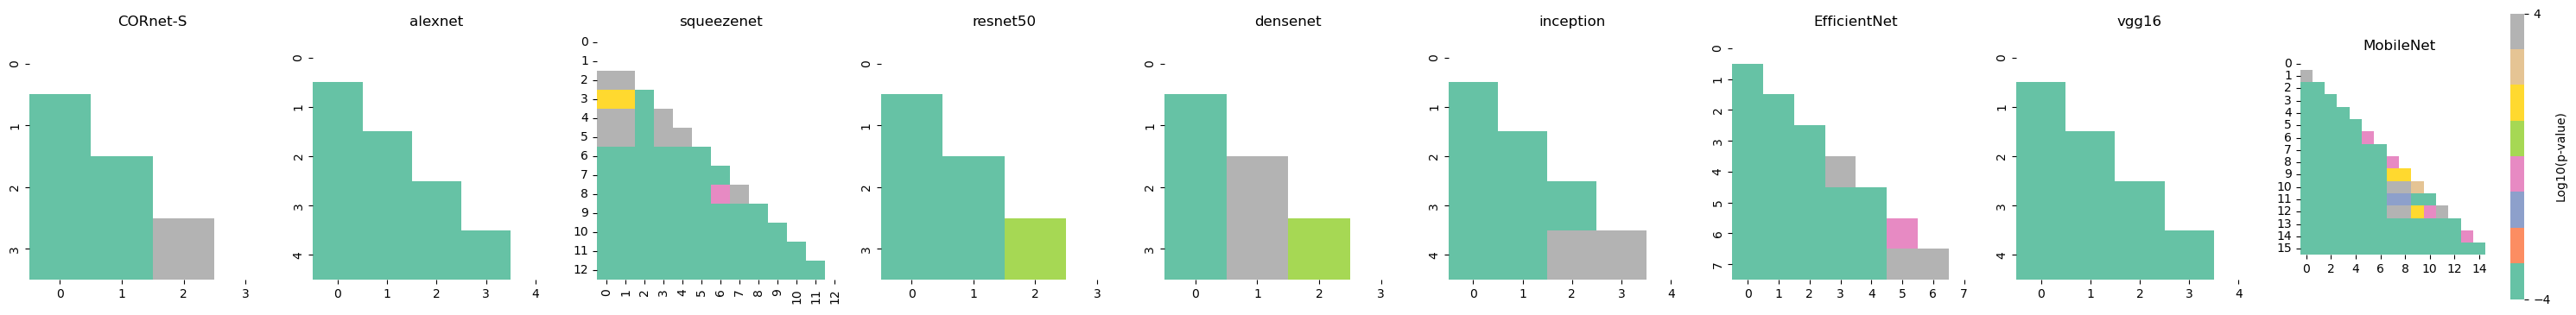

In [8]:
fig_sz = np.array((12,1.5)) * 2.5
plot_clim = [-4,4]
color_pal = 'Set2'

fig1, axs = plt.subplots(figsize=fig_sz, ncols=len(all_model_pval), nrows=1)
for ax,net,net_nm in zip(axs, all_model_pval, all_models):
    sns.heatmap(net, ax=ax, cmap=color_pal, vmin=plot_clim[0], vmax=plot_clim[1], mask=np.triu(net,1), square=True, cbar=False) #, cbar_kws={'label': 'Log10(p-value)'})
    ax.set_title(net_nm)
sns.heatmap(net, ax=ax, cmap=color_pal, vmin=plot_clim[0], vmax=plot_clim[1], mask=np.triu(net,1), square=True, cbar_kws={'label': 'Log10(p-value)', 'ticks': [-4,4]})
plt.tight_layout()

# plt.savefig(f'{FigDir}nn_sim_{myCond}_stat.svg')

  0%|          | 0/9 [00:00<?, ?it/s]

([<matplotlib.axis.YTick at 0x23fa63a2310>,
 [])

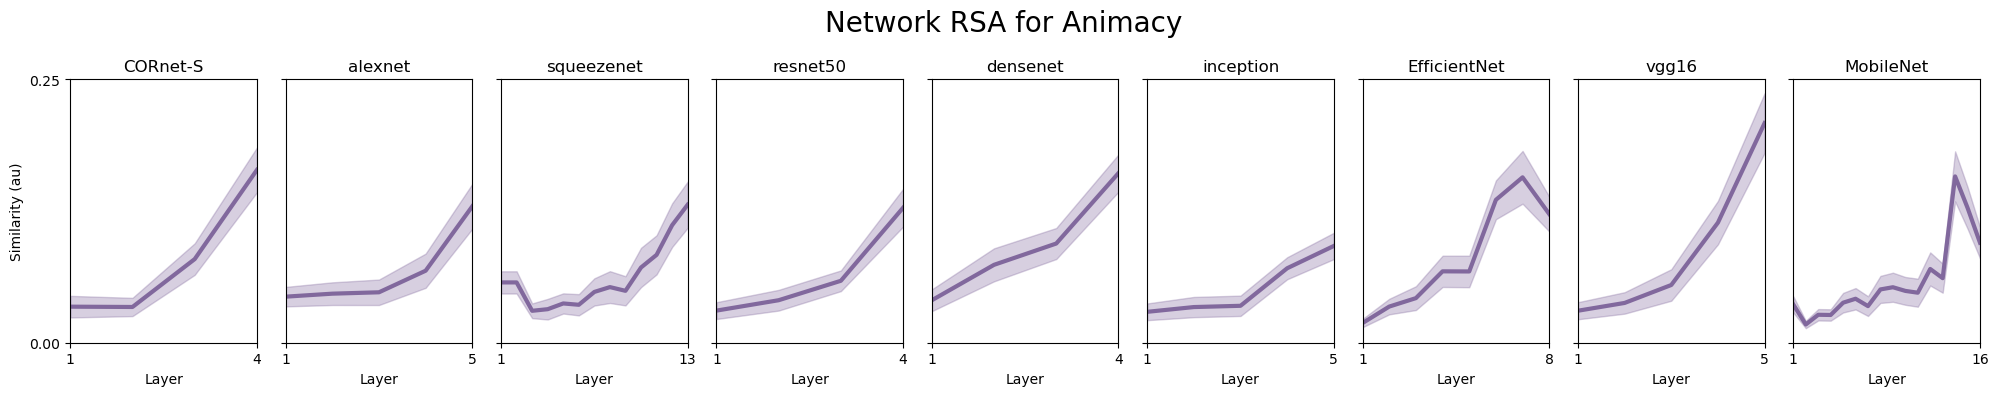

In [107]:
all_models = ['CORnet-S', 'alexnet', 'squeezenet', 'resnet50', 'densenet', 'inception', 'EfficientNet', 'vgg16', 'MobileNet']
fig_sz = (20,4)

all_model_rsa = []
for model in tqdm(all_models):
        with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
                mdl_rep = mk_repmat_mdl(pickle.load(f))
        
        mdl_rsa = []
        for iCycle in range(cycle_num):
                cycle_sim = []
                for rep in mdl_rep:
                        cycle_sim.append(compute_similarity((rep[idx_rand[iCycle]].T)[idx_rand[iCycle]], 
                                                            mk_repmat_kernel([stim_num,stim_num])))
                mdl_rsa.append(cycle_sim)
        all_model_rsa.append(np.array(mdl_rsa))

m_plot_net(all_model_rsa, sub_titles=all_models, figure_size=fig_sz, plot_title=f'Network RSA for {myCond}')
plt.ylim([.0,.25])
plt.yticks([.0,.25])

# plt.savefig(f'{FigDir}nn_sim_{myCond}.svg')

In [109]:
all_mdl_slopes = np.zeros(len(all_models)) * np.nan
all_mdl_r, all_mdl_pval, all_mdl_se, all_mdl_r2 = np.copy(all_mdl_slopes), np.copy(all_mdl_slopes), np.copy(all_mdl_slopes), np.copy(all_mdl_slopes)

for imdl,mdl in enumerate(all_model_rsa):
    tmp_corr_mat_x, tmp_corr_mat_y = np.array(()), np.array(())
    for ilayer,layer in enumerate(mdl.T):
        tmp_corr_mat_x = np.concatenate((tmp_corr_mat_x, np.ones_like(layer)*ilayer), axis=0)
        tmp_corr_mat_y = np.concatenate((tmp_corr_mat_y, layer), axis=0)
    all_mdl_slopes[imdl], _, all_mdl_r[imdl], all_mdl_pval[imdl], all_mdl_se[[imdl]] = linregress(tmp_corr_mat_x, tmp_corr_mat_y)
    all_mdl_r2[imdl] = all_mdl_r[imdl]**2

    print(f'{all_models[imdl]} =>   r2: {all_mdl_r2[imdl]} | p-val: {all_mdl_pval[imdl]} | se: {all_mdl_se[imdl]}')


CORnet-S =>   r2: 0.7803299729317267 | p-val: 7.431240892947986e-265 | se: 0.0008167465571829826
alexnet =>   r2: 0.5935737656312527 | p-val: 2.495265514044796e-197 | se: 0.0005063519795341688
squeezenet =>   r2: 0.4566147011991689 | p-val: 0.0 | se: 0.00012774032619376524
resnet50 =>   r2: 0.7574816086780345 | p-val: 1.0569871807255442e-247 | se: 0.00062348280928323
densenet =>   r2: 0.8451181637808514 | p-val: 0.0 | se: 0.0005792510343339318
inception =>   r2: 0.7317224457856096 | p-val: 2.155353864242342e-287 | se: 0.0003103107887808015
EfficientNet =>   r2: 0.7692748585625694 | p-val: 0.0 | se: 0.0002638180797062233
vgg16 =>   r2: 0.7874358046602775 | p-val: 0.0 | se: 0.0007113341003181358
MobileNet =>   r2: 0.5698612601270824 | p-val: 0.0 | se: 9.889045302146451e-05


In [12]:
fig_sz = np.array((12,1.5)) * 1.5
plot_clim = [-4,4]
color_pal = 'Set2'

all_model_pval = []
for mdl in tqdm(all_model_rsa):
    tmp_pval = np.zeros((mdl.T.shape[0],mdl.T.shape[0])) * np.nan

    for i_layer1,layer1 in enumerate(mdl.T):
        for i_layer2,layer2 in enumerate(mdl.T):
            if np.nanmedian(layer2) >np.nanmedian(layer1):
                tmp_pval[i_layer1,i_layer2] = abs(log10(comp_permute_p(layer1, layer2)))
            elif np.nanmedian(layer1) >np.nanmedian(layer2):
                tmp_pval[i_layer1,i_layer2] = -abs(log10(comp_permute_p(layer1, layer2)))
    
    all_model_pval.append(tmp_pval)


  0%|          | 0/9 [00:00<?, ?it/s]

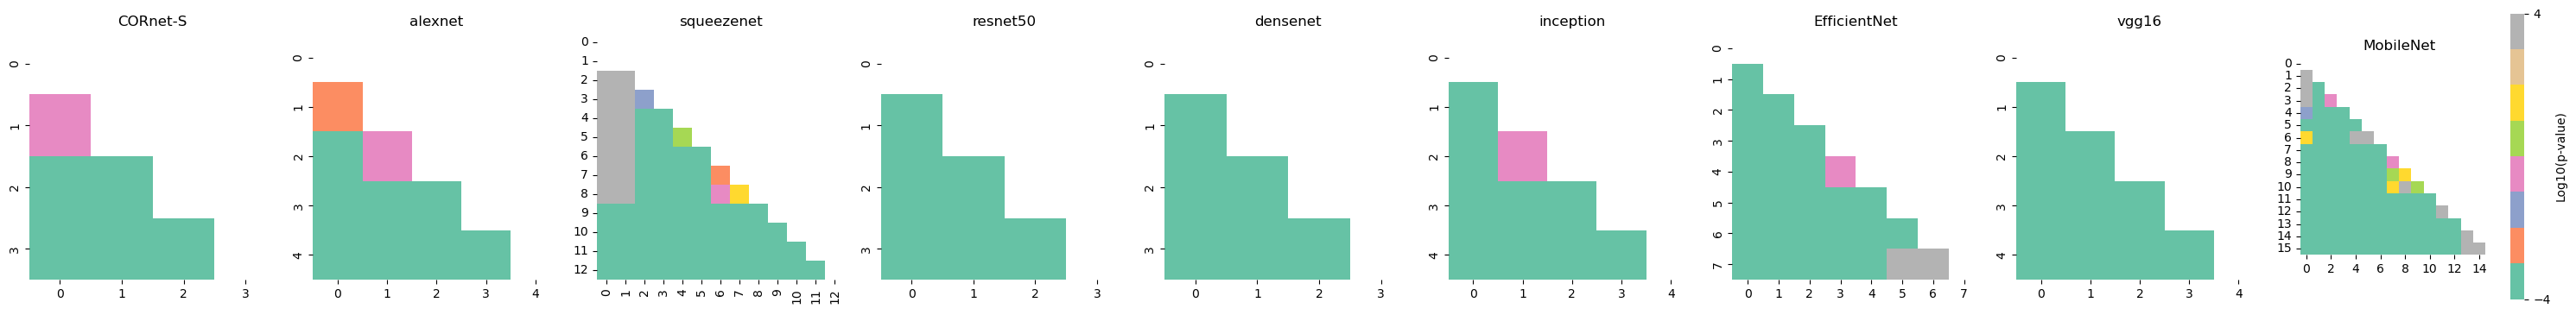

In [15]:
fig_sz = np.array((12,1.5)) * 2.5
plot_clim = [-4,4]
color_pal = 'Set2'

fig1, axs = plt.subplots(figsize=fig_sz, ncols=len(all_model_pval), nrows=1)
for ax,net,net_nm in zip(axs, all_model_pval, all_models):
    sns.heatmap(net, ax=ax, cmap=color_pal, vmin=plot_clim[0], vmax=plot_clim[1], mask=np.triu(net,1), square=True, cbar=False) #, cbar_kws={'label': 'Log10(p-value)'})
    ax.set_title(net_nm)
sns.heatmap(net, ax=ax, cmap=color_pal, vmin=plot_clim[0], vmax=plot_clim[1], mask=np.triu(net,1), square=True, cbar_kws={'label': 'Log10(p-value)', 'ticks': [-4,4]})
plt.tight_layout()

# plt.savefig(f'{FigDir}nn_sim_{myCond}_stat.svg')

## NN ~ Brain ##

In [56]:
all_models = ['CORnet-S', 'alexnet']
mdl_ind = 0

last_layer_rep = []
for model in tqdm(all_models):
    with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
        mdl_resp = pickle.load(f)
    last_layer_rep.append(mk_repmat_mdl({list(mdl_resp.keys())[-1]: mdl_resp[list(mdl_resp.keys())[-1]]},stim_idx=ind_all).squeeze())
last_layer_rep = np.array(last_layer_rep)

tmp_net_rep = last_layer_rep[mdl_ind]
tmp_mdl_name = all_models[mdl_ind]

itc, pfc = [], []
for iCycle in tqdm(range(cycle_num)):
   itc.append(compute_rsa(resp_itc[:,idx_rand[iCycle],:], sp_kernel=(tmp_net_rep[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
   pfc.append(compute_rsa(resp_pfc[:,idx_rand[iCycle],:], sp_kernel=(tmp_net_rep[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
itc = np.array(itc)
pfc = np.array(pfc)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

ITC = 0.44 -+ 0.02
PFC = 0.36 -+ 0.03
Mann-Whitney p = 2.445961248066568e-62
Permutation p = 1.999960000799984e-05


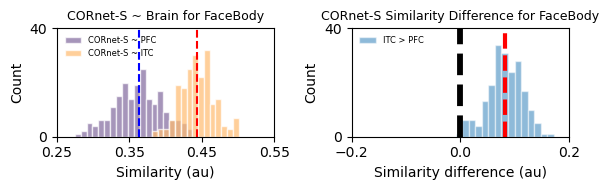

In [54]:
plot_xlim = [.25,.55]
diff_xlim = [-.2,.2]
plot_ylim = [0,40]
figure_size = np.array((3,1)) * 2

peak_val_itc = np.array(itc).max(axis=1)
peak_val_pfc = np.array(pfc).max(axis=1)
diffs = peak_val_itc - peak_val_pfc

fig1, axs = plt.subplots(figsize=figure_size, ncols=2, nrows=1)
axs[0].hist(peak_val_pfc, bins=20, color=color_pfc_n[:3], alpha=.7, label='CORnet-S ~ PFC', edgecolor=[1,1,1])
axs[0].hist(peak_val_itc, bins=15, color=color_itc_n[:3], alpha=.7, label='CORnet-S ~ ITC', edgecolor=[1,1,1])
axs[0].axvline(np.nanmedian(peak_val_itc), ls='--', color='r')
axs[0].axvline(np.nanmedian(peak_val_pfc), ls='--', color='b')
axs[0].set_xlim(plot_xlim)
axs[0].set_xticks(np.arange(plot_xlim[0],plot_xlim[1],.1))
axs[0].set_yticks([plot_ylim[0],plot_ylim[1]])
axs[0].set_xlabel('Similarity (au)')
axs[0].set_ylabel('Count')
axs[0].set_title(f'{tmp_mdl_name} ~ Brain for {myCond}', fontsize=figure_size[0]*1.5)
axs[0].legend(frameon=False, fontsize=figure_size[0])

axs[1].hist(diffs, bins=15, alpha=.5, label='ITC > PFC', edgecolor=[1,1,1])
axs[1].set_xlim(diff_xlim)
axs[1].set_xticks([diff_xlim[0],0,diff_xlim[1]])
axs[1].set_yticks([plot_ylim[0],plot_ylim[1]])
axs[1].axvline(0, ls='--', color='k', lw=figure_size[0]*.7)
axs[1].axvline(np.nanmedian(diffs), ls='--', color='r', lw=figure_size[0]*.5)
axs[1].set_xlabel('Similarity difference (au)')
axs[1].set_ylabel('Count')
axs[1].set_title(f'{tmp_mdl_name} Similarity Difference for {myCond}', fontsize=figure_size[0]*1.5)
axs[1].legend(frameon=False, fontsize=figure_size[0])

plt.tight_layout()

print(f'ITC = {np.nanmedian(peak_val_itc).round(2)} -+ {np.nanstd(peak_val_itc).round(2)}')
print(f'PFC = {np.nanmedian(peak_val_pfc).round(2)} -+ {np.nanstd(peak_val_pfc).round(2)}')
print(f"Mann-Whitney p = {mnu(peak_val_itc, peak_val_pfc, nan_policy='omit')[1]}")
print(f"Permutation p = {comp_permute_p(peak_val_itc, peak_val_pfc)}")

# plt.savefig(f'{FigDir}brain_{tmp_mdl_name}_sim_{myCond}_stat.svg')

Text(12.597222222222223, 0.5, 'Similarity (au)')

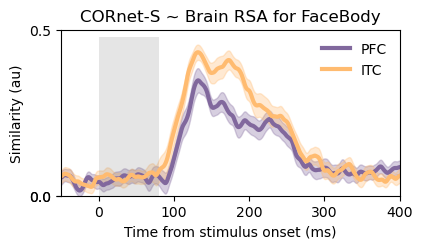

In [53]:
plot_xlim = [-50,400]
plot_ylim = [.0,.5]
fig_sz = np.array((2,1.2)) * 2
smooth_win = 2

m_plot([pfc,itc], [color_pfc,color_itc], error_method='std', smooth_win=smooth_win, labels=['PFC','ITC'], 
       plot_title=f'{tmp_mdl_name} ~ Brain RSA for {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

# plt.savefig(f'{FigDir}brain_{tmp_mdl_name}_sim_{myCond}.svg')

ITC = 0.18 -+ 0.02
PFC = 0.15 -+ 0.02
Mann-Whitney p = 7.634235332993911e-27
Permutation p = 1.999960000799984e-05


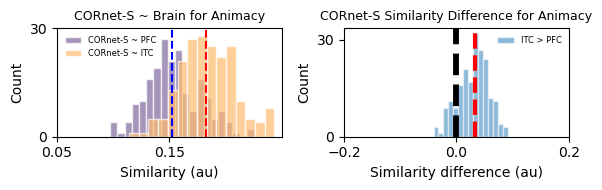

In [57]:
plot_xlim = [.05,.25]
diff_xlim = [-.2,.2]
plot_ylim = [0,30]
figure_size = np.array((3,1)) * 2

peak_val_itc = np.array(itc).max(axis=1)
peak_val_pfc = np.array(pfc).max(axis=1)
diffs = peak_val_itc - peak_val_pfc

fig1, axs = plt.subplots(figsize=figure_size, ncols=2, nrows=1)
axs[0].hist(peak_val_pfc, bins=20, color=color_pfc_n[:3], alpha=.7, label='CORnet-S ~ PFC', edgecolor=[1,1,1])
axs[0].hist(peak_val_itc, bins=15, color=color_itc_n[:3], alpha=.7, label='CORnet-S ~ ITC', edgecolor=[1,1,1])
axs[0].axvline(np.nanmedian(peak_val_itc), ls='--', color='r')
axs[0].axvline(np.nanmedian(peak_val_pfc), ls='--', color='b')
axs[0].set_xlim(plot_xlim)
axs[0].set_xticks(np.arange(plot_xlim[0],plot_xlim[1],.1))
axs[0].set_yticks([plot_ylim[0],plot_ylim[1]])
axs[0].set_xlabel('Similarity (au)')
axs[0].set_ylabel('Count')
axs[0].set_title(f'{tmp_mdl_name} ~ Brain for {myCond}', fontsize=figure_size[0]*1.5)
axs[0].legend(frameon=False, fontsize=figure_size[0])

axs[1].hist(diffs, bins=15, alpha=.5, label='ITC > PFC', edgecolor=[1,1,1])
axs[1].set_xlim(diff_xlim)
axs[1].set_xticks([diff_xlim[0],0,diff_xlim[1]])
axs[1].set_yticks([plot_ylim[0],plot_ylim[1]])
axs[1].axvline(0, ls='--', color='k', lw=figure_size[0]*.7)
axs[1].axvline(np.nanmedian(diffs), ls='--', color='r', lw=figure_size[0]*.5)
axs[1].set_xlabel('Similarity difference (au)')
axs[1].set_ylabel('Count')
axs[1].set_title(f'{tmp_mdl_name} Similarity Difference for {myCond}', fontsize=figure_size[0]*1.5)
axs[1].legend(frameon=False, fontsize=figure_size[0])

plt.tight_layout()

print(f'ITC = {np.nanmedian(peak_val_itc).round(2)} -+ {np.nanstd(peak_val_itc).round(2)}')
print(f'PFC = {np.nanmedian(peak_val_pfc).round(2)} -+ {np.nanstd(peak_val_pfc).round(2)}')
print(f"Mann-Whitney p = {mnu(peak_val_itc, peak_val_pfc, nan_policy='omit')[1]}")
print(f"Permutation p = {comp_permute_p(peak_val_itc, peak_val_pfc)}")

# plt.savefig(f'{FigDir}brain_{tmp_mdl_name}_sim_{myCond}_stat.svg')

Text(-7.902777777777777, 0.5, 'Similarity (au)')

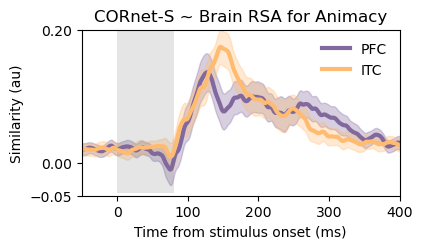

In [59]:
plot_xlim = [-50,400]
plot_ylim = [-.05,.2]
fig_sz = np.array((2,1.2)) * 2
smooth_win = 2

m_plot([pfc,itc], [color_pfc,color_itc], error_method='std', smooth_win=smooth_win, labels=['PFC','ITC'], 
       plot_title=f'{tmp_mdl_name} ~ Brain RSA for {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

# plt.savefig(f'{FigDir}brain_{tmp_mdl_name}_sim_{myCond}.svg')

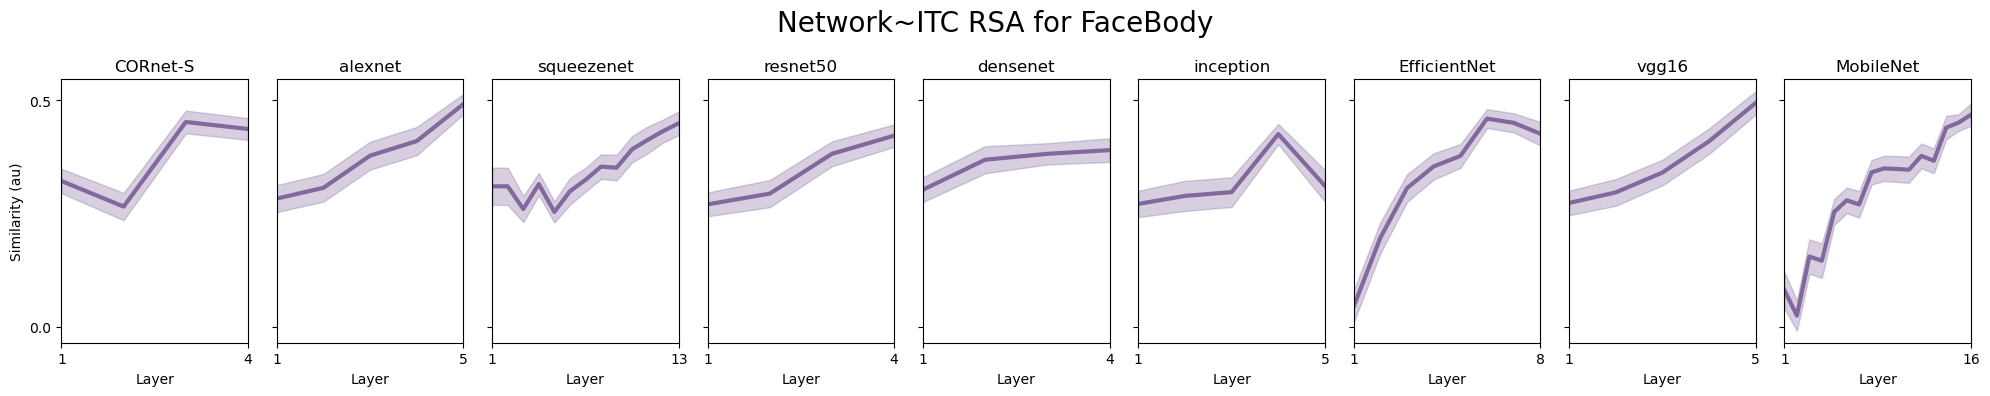

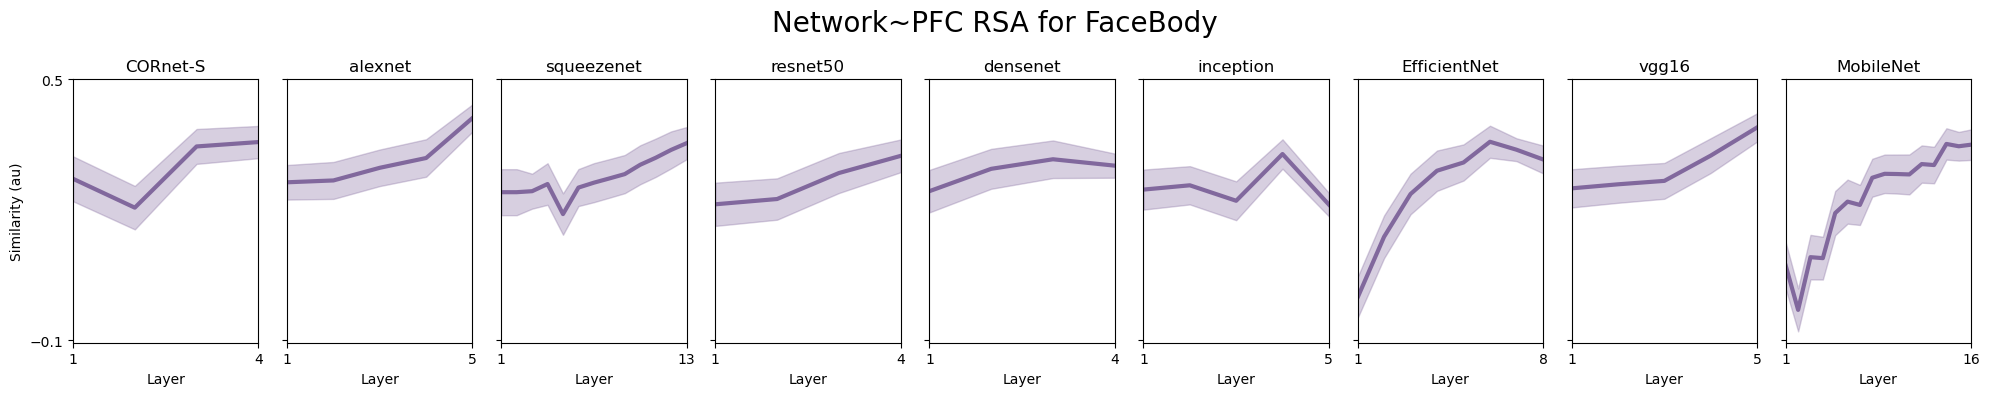

In [ ]:
fig_sz = np.array((5,1)) * 4
all_models = ['CORnet-S', 'alexnet', 'squeezenet', 'resnet50', 'densenet', 'inception', 'EfficientNet', 'vgg16', 'MobileNet']

base_time_idx = (time_stamps>-50) & (time_stamps<50)
peaksss_itc = FindResp(itc, time_stamps, base_time_idx, resp_win=[-100,600])[1]
peaksss_pfc = FindResp(pfc, time_stamps, base_time_idx, resp_win=[-100,600])[1]

idx_peak_itc = np.argmin(abs((time_stamps - np.nanmedian(peaksss_itc))))
idx_peak_pfc = np.argmin(abs((time_stamps - np.nanmedian(peaksss_pfc))))


peak_repmat_itc = mk_repmat_data(resp_itc[:,ind_all,idx_peak_itc])
peak_repmat_pfc = mk_repmat_data(resp_pfc[:,ind_all,idx_peak_pfc])

all_model_rsa_itc, all_model_rsa_pfc = [], []
for model in tqdm(all_models):
        with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
                mdl_rep = mk_repmat_mdl(pickle.load(f))
        
        mdl_rsa_itc, mdl_rsa_pfc = [], []
        for iCycle in range(cycle_num):
                cycle_sim_itc, cycle_sim_pfc = [], []
                for rep in mdl_rep:
                        cycle_sim_itc.append(compute_similarity((rep[idx_rand[iCycle]].T)[idx_rand[iCycle]], 
                                                            mk_repmat_data(resp_itc[:,idx_rand[iCycle],idx_peak_itc])))
                        cycle_sim_pfc.append(compute_similarity((rep[idx_rand[iCycle]].T)[idx_rand[iCycle]], 
                                                            mk_repmat_data(resp_pfc[:,idx_rand[iCycle],idx_peak_pfc])))
                mdl_rsa_itc.append(cycle_sim_itc)
                mdl_rsa_pfc.append(cycle_sim_pfc)
        all_model_rsa_itc.append(np.array(mdl_rsa_itc))
        all_model_rsa_pfc.append(np.array(mdl_rsa_pfc))

m_plot_net(all_model_rsa_itc, sub_titles=all_models, figure_size=fig_sz, plot_title=f'Network~ITC RSA for {myCond}')
m_plot_net(all_model_rsa_pfc, sub_titles=all_models, figure_size=fig_sz, plot_title=f'Network~PFC RSA for {myCond}')
# plt.ylim([.0,.25])
# plt.yticks([.0,.25])

clear_output()
# plt.savefig(f'{FigDir}nn_sim_{myCond}.svg')

# Extremization

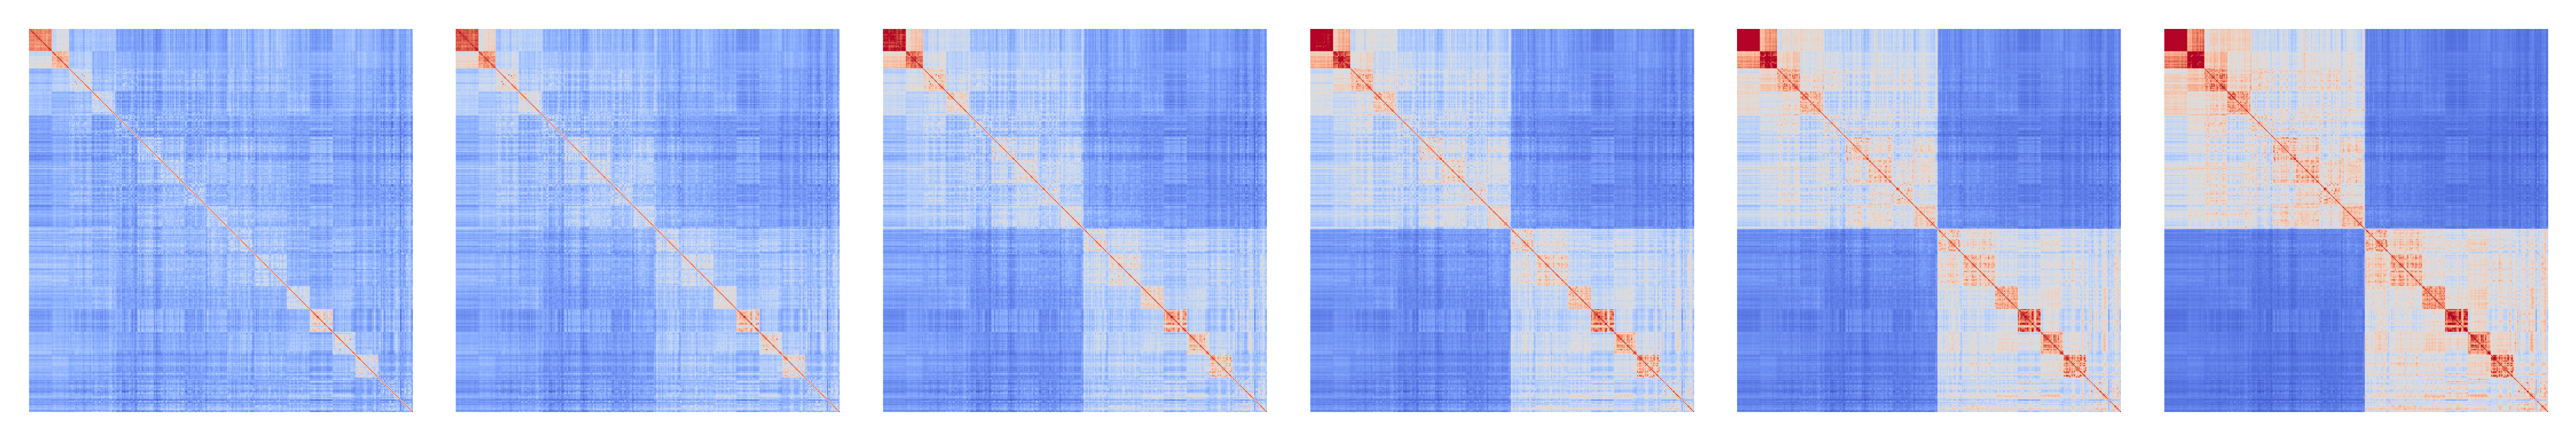

In [ ]:
coeffs = np.arange(0,.51,.1)
coeffs_a = 1 - coeffs
coeffs_b = 1 + coeffs

repmats = []
for coeff_a,coeff_b in zip(list(coeffs_a), list(coeffs_b)):
    repmats.append(
        repmat_extremizer(tmp_net_rep, szs_ls=[indc1.shape[0],indc2.shape[0]], coeffs=[coeff_a, coeff_b]))

plot_repmat(repmats)

In [104]:
itc, pfc = [], []
for tmp_repmat in repmats:
      tmp_itc, tmp_pfc = [], []
      for iCycle in tqdm(range(cycel_num)):
            tmp_itc.append(compute_rsa(resp_itc[:,idx_rand[iCycle],:], sp_kernel=(tmp_repmat[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
            tmp_pfc.append(compute_rsa(resp_pfc[:,idx_rand[iCycle],:], sp_kernel=(tmp_repmat[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
      itc.append(np.array(tmp_itc))
      pfc.append(np.array(tmp_pfc))


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'Similarity (au)')

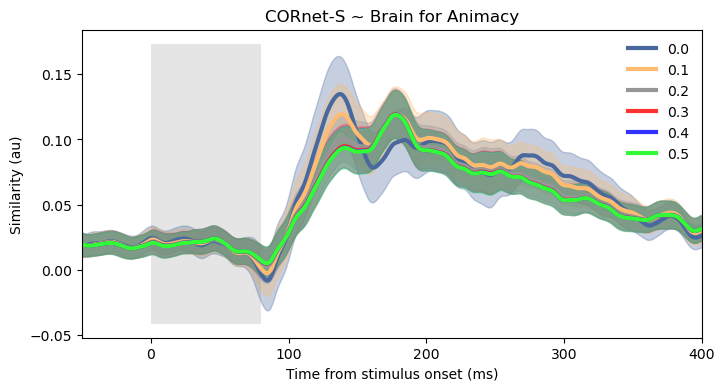

In [109]:
plot_xlim = [-50,400]
plot_ylim = [-.05,.2]
fig_sz = (8,4)
colors = [[73, 104, 157, 80],
          [255, 187, 112, 80], 
          [150, 150, 150, 80],
          [255, 50, 50, 80], 
          [50, 50, 255, 80],
          [50, 250, 55, 80]]

m_plot(np.array(pfc), 3, colors, ['0.0', '0.1','0.2','0.3','0.4','0.5'],
       f'{tmp_mdl_name} ~ Brain for {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

med: 209.0, std: 24.28410951630716
med: 240.0, std: 25.9026543041442
med: 247.0, std: 19.50562418893587
med: 247.0, std: 16.717128940102125
med: 247.0, std: 16.489068348454378
med: 247.0, std: 16.68685036188675


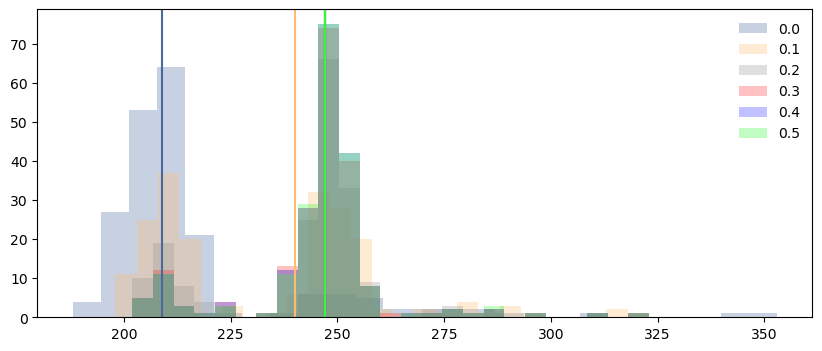

In [116]:
pfc = np.array(pfc)
peaks = pfc.argmax(axis=2)
labels = ['0.0','0.1','0.2','0.3','0.4','0.5']
colors = [[73/255, 104/255, 157/255],
          [255/255, 187/255, 112/255], 
          [150/255, 150/255, 150/255],
          [255/255, 50/255, 50/255], 
          [50/255, 50/255, 255/255],
          [50/255, 250/255, 55/255]]

plt.figure(figsize=(10,4))
for i,rep in enumerate(peaks):
    plt.hist(rep, bins=25, label=labels[i], color=colors[i], alpha=.3)
    plt.axvline(np.nanmedian(rep), color=colors[i])
    print(f'med: {np.nanmedian(rep)}, std: {np.nanstd(rep)}')
plt.legend(frameon=False)

Text(0, 0.5, 'Similarity (au)')

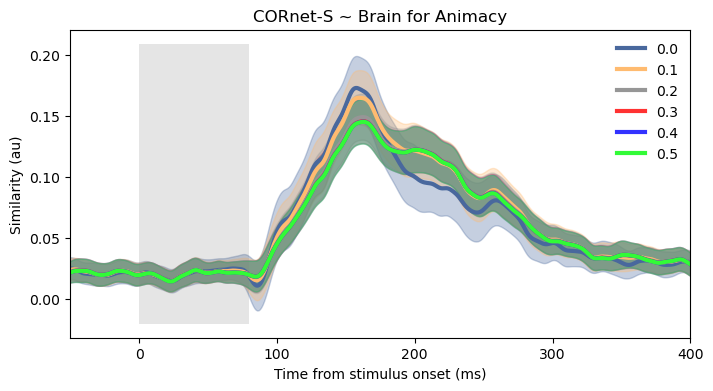

In [111]:
plot_xlim = [-50,400]
plot_ylim = [-.05,.2]
fig_sz = (8,4)
colors = [[73, 104, 157, 80],
          [255, 187, 112, 80], 
          [150, 150, 150, 80],
          [255, 50, 50, 80], 
          [50, 50, 255, 80],
          [50, 250, 55, 80]]

m_plot(np.array(itc), 3, colors, ['0.0', '0.1','0.2','0.3','0.4','0.5'],
       f'{tmp_mdl_name} ~ Brain for {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

med: 226.0, std: 7.731823846932883
med: 230.0, std: 8.254209532111478
med: 233.5, std: 14.123384863410045
med: 233.5, std: 14.388779482638546
med: 234.0, std: 14.650698788795024
med: 234.0, std: 14.650698788795024


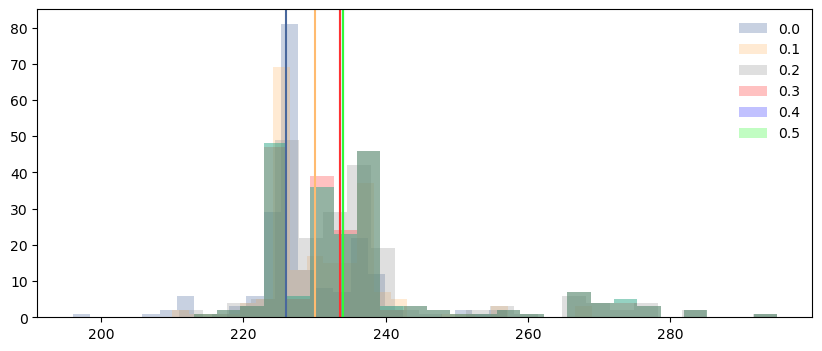

In [117]:
itc = np.array(itc)
peaks = itc.argmax(axis=2)
labels = ['0.0','0.1','0.2','0.3','0.4','0.5']
colors = [[73/255, 104/255, 157/255],
          [255/255, 187/255, 112/255], 
          [150/255, 150/255, 150/255],
          [255/255, 50/255, 50/255], 
          [50/255, 50/255, 255/255],
          [50/255, 250/255, 55/255]]

plt.figure(figsize=(10,4))
for i,rep in enumerate(peaks):
    plt.hist(rep, bins=25, label=labels[i], color=colors[i], alpha=.3)
    plt.axvline(np.nanmedian(rep), color=colors[i])
    print(f'med: {np.nanmedian(rep)}, std: {np.nanstd(rep)}')
plt.legend(frameon=False)


# Peak Similarity

In [ ]:
all_models = ['CORnet-S', 'alexnet', 'squeezenet', 'resnet50', 'densenet', 'inception', 'EfficientNet', 'vgg16', 'MobileNet']

all_model_rsa = []
for model in tqdm(all_models):
        with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
                mdl_rep = mk_repmat_mdl(pickle.load(f))[-1]
        
        mdl_rsa = []
        for iCycle in range(cycle_num):
                mdl_rsa.append(compute_similarity((mdl_rep[idx_rand[iCycle]].T)[idx_rand[iCycle]], 
                                                  mk_repmat_kernel([stim_num,stim_num])))
        all_model_rsa.append(np.array(mdl_rsa))

all_model_rsa = np.array(all_model_rsa)

# plt.savefig(f'{FigDir}allnet_sim_{myCond}.svg')


  0%|          | 0/9 [00:00<?, ?it/s]

Highest similarity for FaceBody: Vgg16 = 0.62 -+ 0.02


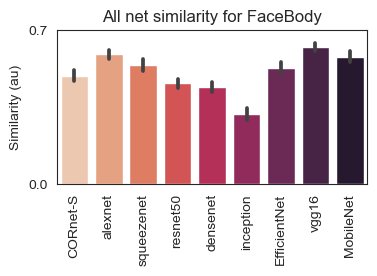

In [ ]:
fig_sz = np.array([2,1]) * 2
plt_ylim = [0,.7]

all_mdl_rsa_df = pd.DataFrame(all_model_rsa.T, columns=all_models)

sns.set_style('white')
plt.figure(figsize=fig_sz)
sim_bar = sns.barplot(data=all_mdl_rsa_df, palette='rocket_r', errorbar='sd')
sim_bar.set_xticklabels(sim_bar.get_xticklabels(), rotation=90)

plt.title(f'All net similarity for {myCond}')
plt.ylabel('Similarity (au)')
plt.ylim(plt_ylim)
plt.yticks(plt_ylim)

highest_sim_idx = all_mdl_rsa_df.mean(axis=0).argmax()
print(f'Highest similarity for {myCond}: {all_mdl_rsa_df.columns[highest_sim_idx].capitalize()} = {all_mdl_rsa_df.mean(axis=0)[highest_sim_idx].round(2)} -+ {all_mdl_rsa_df.std(axis=0)[highest_sim_idx].round(2)}')

# plt.savefig(f'{FigDir}allnet_sim_{myCond}.svg')

Highest similarity for Animacy: Vgg16 = 0.21 -+ 0.03


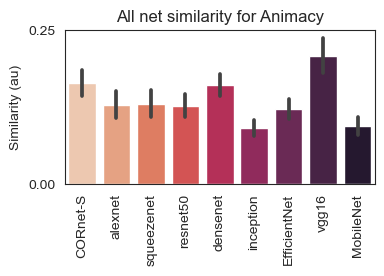

In [ ]:
fig_sz = np.array([2,1]) * 2
plt_ylim = [0,.25]

all_mdl_rsa_df = pd.DataFrame(all_model_rsa.T, columns=all_models)

sns.set_style('white')
plt.figure(figsize=fig_sz)
sim_bar = sns.barplot(data=all_mdl_rsa_df, palette='rocket_r', errorbar='sd')
sim_bar.set_xticklabels(sim_bar.get_xticklabels(), rotation=90)

plt.title(f'All net similarity for {myCond}')
plt.ylabel('Similarity (au)')
plt.ylim(plt_ylim)
plt.yticks(plt_ylim)

highest_sim_idx = all_mdl_rsa_df.mean(axis=0).argmax()
print(f'Highest similarity for {myCond}: {all_mdl_rsa_df.columns[highest_sim_idx].capitalize()} = {all_mdl_rsa_df.mean(axis=0)[highest_sim_idx].round(2)} -+ {all_mdl_rsa_df.std(axis=0)[highest_sim_idx].round(2)}')

# plt.savefig(f'{FigDir}allnet_sim_{myCond}.svg')

# All NNs vs. Brain

In [46]:
all_models = ['CORnet-S', 'CORnet-RT', 'CORnet-Z', 'alexnet', 'squeezenet', 'resnet50', 'densenet', 'inception', 'EfficientNet', 'vgg16', 'vgg19', 'MobileNet']

last_layer_rep = []
itc, pfc = [], []

for model in tqdm(all_models):
    with open(f'{FilesDir}{model}-netrep.pkl', 'rb') as f:
        mdl_resp = pickle.load(f)
    tmp_mdl_rep = mk_repmat_mdl({list(mdl_resp.keys())[-1]: mdl_resp[list(mdl_resp.keys())[-1]]},stim_idx=ind_all).squeeze()
    
    tmp_itc, tmp_pfc = [], []
    for iCycle in range(cycle_num):
        tmp_itc.append(compute_rsa(resp_itc[:,idx_rand[iCycle],:], sp_kernel=(tmp_mdl_rep[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
        tmp_pfc.append(compute_rsa(resp_pfc[:,idx_rand[iCycle],:], sp_kernel=(tmp_mdl_rep[idx_rand[iCycle]].T)[idx_rand[iCycle]]))
    
    itc.append(np.array(tmp_itc))
    pfc.append(np.array(tmp_pfc))

itc = np.array(itc)
pfc = np.array(pfc)

ave_itc = np.nanmean(itc, axis=1)
ave_pfc = np.nanmean(pfc, axis=1)

  0%|          | 0/12 [00:00<?, ?it/s]

Text(12.597222222222223, 0.5, 'Similarity (au)')

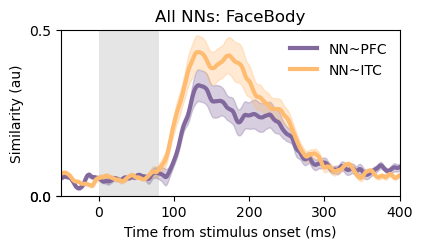

In [48]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.5]
fig_sz = np.array((2,1.2)) * 2

m_plot([ave_pfc,ave_itc], [color_pfc,color_itc], error_method='std', smooth_win=smooth_win, labels=['NN~PFC','NN~ITC'], 
       plot_title=f'All NNs: {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

# plt.savefig(f'{FigDir}brain_allnets_sim_{myCond}.svg')

ITC = 0.45553917538722616 -+ 0.04902186109336082
PFC = 0.3532351036156349 -+ 0.04415302416259268
Wilcoxon p = 0.00048828125


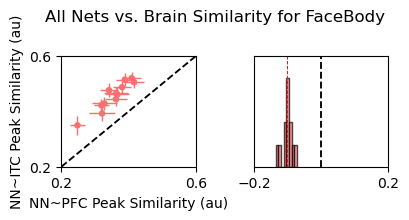

In [34]:
peak_itc_ave = np.nanmean(np.array(itc).max(axis=2), axis=1)
peak_pfc_ave = np.nanmean(np.array(pfc).max(axis=2), axis=1)

peak_itc_std = np.nanstd(np.array(itc).max(axis=2), axis=1)
peak_pfc_std = np.nanstd(np.array(pfc).max(axis=2), axis=1)

fig_sz = np.array((2,1)) * 2
scatter_lim = [.2,.6]
hist_xlim = [-.2,.2]
hist_ylim = [0,5]

fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_sz)
fig1.suptitle(f'All Nets vs. Brain Similarity for {myCond}')
fig1.tight_layout()

# scatter
axs[0].scatter(peak_pfc_ave, peak_itc_ave, color=diff_color, s=fig_sz[0]**2.2, edgecolor='none')
axs[0].errorbar(peak_pfc_ave, peak_itc_ave, xerr=peak_pfc_std, yerr=peak_itc_std,
                fmt='.', color=diff_color, elinewidth=fig_sz[0]/4)

# for i, txt in enumerate(all_models): axs[0].annotate(txt, (peak_pfc_ave[i], peak_itc_ave[i]), fontsize=fig_sz[0]*.7)
axs[0].axline((0, 0), color='k', ls='--', lw=fig_sz[0]/3, slope=1)

axs[0].set_xlabel('NN~PFC Peak Similarity (au)')
axs[0].set_xlim(scatter_lim)
axs[0].set_xticks(scatter_lim)

axs[0].set_ylabel('NN~ITC Peak Similarity (au)')
axs[0].set_ylim(scatter_lim)
axs[0].set_yticks(scatter_lim)

# histogram
sim_diffs = peak_pfc_ave - peak_itc_ave

axs[1].hist(sim_diffs, color=diff_color, edgecolor='k', alpha=.7, bins=8)
axs[1].axvline(0, ls='--', color='k', lw=fig_sz[0]/3)
axs[1].axvline(np.nanmedian(sim_diffs), ls='--', color='r', lw=fig_sz[0]/6)

axs[1].set_xlabel('')
axs[1].set_xlim(hist_xlim)
axs[1].set_xticks(hist_xlim)

axs[1].set_ylabel('')
axs[1].set_ylim(hist_ylim)
axs[1].set_yticks([])

print(f'ITC = {np.nanmean(peak_itc_ave)} -+ {np.nanstd(peak_itc_ave)}')
print(f'PFC = {np.nanmean(peak_pfc_ave)} -+ {np.nanstd(peak_pfc_ave)}')
print(f"Wilcoxon p = {wilcoxon(sim_diffs, nan_policy='omit', method='exact', zero_method='zsplit')[1]}")

# plt.savefig(f'{FigDir}brain_allnets_sim_{myCond}_stat.svg')

Highest similarity to ITC for FaceBody: Vgg16 = 0.52 -+ 0.02
Highest similarity to PFC for FaceBody: Alexnet = 0.42 -+ 0.03


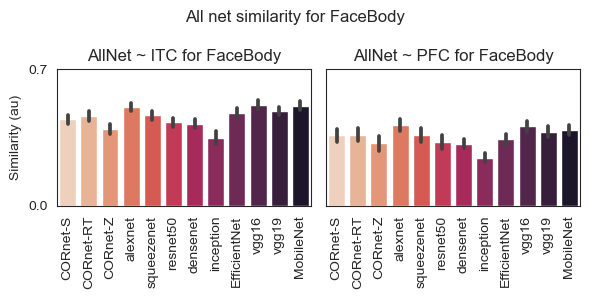

In [ ]:
fig_sz = np.array([2,1]) * 3
plt_ylim = [0,.7]

all_peaks_itc = np.array(itc).max(axis=2)
all_peaks_pfc = np.array(pfc).max(axis=2)
all_mdl_itc_df = pd.DataFrame(all_peaks_itc.T, columns=all_models)
all_mdl_pfc_df = pd.DataFrame(all_peaks_pfc.T, columns=all_models)

sns.set_style('white')
fig1, axs = plt.subplots(figsize=fig_sz, nrows=1, ncols=2, sharey=True)

sim_bar_itc = sns.barplot(data=all_mdl_itc_df, palette='rocket_r', errorbar='sd', ax=axs[0])
sim_bar_itc.set_xticklabels(sim_bar_itc.get_xticklabels(), rotation=90)
axs[0].set_title(f'AllNet ~ ITC for {myCond}')
axs[0].set_ylabel('Similarity (au)')
axs[0].set_ylim(plt_ylim)
axs[0].set_yticks(plt_ylim)

sim_bar_pfc = sns.barplot(data=all_mdl_pfc_df, palette='rocket_r', errorbar='sd', ax=axs[1])
sim_bar_pfc.set_xticklabels(sim_bar_pfc.get_xticklabels(), rotation=90)
axs[1].set_title(f'AllNet ~ PFC for {myCond}')
axs[1].set_ylabel('')
# axs[0].set_ylim(plt_ylim)
# axs[0].set_yticks(plt_ylim)

plt.suptitle(f'All net similarity for {myCond}')
plt.tight_layout()

highest_sim_idx_itc = all_mdl_itc_df.mean(axis=0).argmax()
print(f'Highest similarity to ITC for {myCond}: {all_mdl_itc_df.columns[highest_sim_idx_itc].capitalize()} = {all_mdl_itc_df.mean(axis=0)[highest_sim_idx_itc].round(2)} -+ {all_mdl_itc_df.std(axis=0)[highest_sim_idx_itc].round(2)}')

highest_sim_idx_pfc = all_mdl_pfc_df.mean(axis=0).argmax()
print(f'Highest similarity to PFC for {myCond}: {all_mdl_pfc_df.columns[highest_sim_idx_pfc].capitalize()} = {all_mdl_pfc_df.mean(axis=0)[highest_sim_idx_pfc].round(2)} -+ {all_mdl_pfc_df.std(axis=0)[highest_sim_idx_pfc].round(2)}')

# plt.savefig(f'{FigDir}allnet_toBrain_sim_{myCond}.svg')

Text(7.597222222222223, 0.5, 'Similarity (au)')

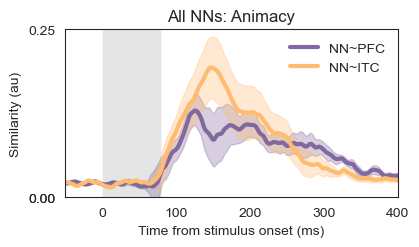

In [103]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.25]
fig_sz = np.array((2,1.2)) * 2

m_plot([ave_pfc,ave_itc], [color_pfc,color_itc], error_method='std', smooth_win=smooth_win, labels=['NN~PFC','NN~ITC'], 
       plot_title=f'All NNs: {myCond}', timepoints=time_stamps, figure_size=fig_sz)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

# plt.savefig(f'{FigDir}brain_allnets_sim_{myCond}.svg')

ITC = 0.20710623150691174 -+ 0.04164129063776931
PFC = 0.1595177782149502 -+ 0.019807734357672316
Wilcoxon p = 0.00048828125


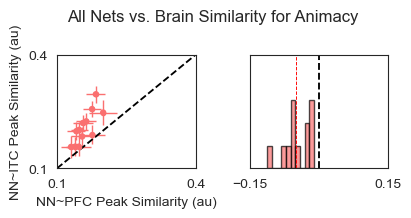

In [75]:
peak_itc_ave = np.nanmean(np.array(itc).max(axis=2), axis=1)
peak_pfc_ave = np.nanmean(np.array(pfc).max(axis=2), axis=1)

peak_itc_std = np.nanstd(np.array(itc).max(axis=2), axis=1)
peak_pfc_std = np.nanstd(np.array(pfc).max(axis=2), axis=1)

fig_sz = np.array((8,4)) *.5
scatter_lim = [.1,.4]
hist_xlim = [-.15,.15]
hist_ylim = [0,5]

fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_sz)
fig1.suptitle(f'All Nets vs. Brain Similarity for {myCond}')
fig1.tight_layout()

# scatter
axs[0].scatter(peak_pfc_ave, peak_itc_ave, color=diff_color, s=fig_sz[0]**2.2, edgecolor='none')
axs[0].errorbar(peak_pfc_ave, peak_itc_ave, xerr=peak_pfc_std, yerr=peak_itc_std,
                fmt='.', color=diff_color, elinewidth=fig_sz[0]/4)

# for i, txt in enumerate(all_models): axs[0].annotate(txt, (peak_pfc_ave[i], peak_itc_ave[i]), fontsize=fig_sz[0]*.7)
axs[0].axline((0, 0), color='k', ls='--', lw=fig_sz[0]/3, slope=1)

axs[0].set_xlabel('NN~PFC Peak Similarity (au)')
axs[0].set_xlim(scatter_lim)
axs[0].set_xticks(scatter_lim)

axs[0].set_ylabel('NN~ITC Peak Similarity (au)')
axs[0].set_ylim(scatter_lim)
axs[0].set_yticks(scatter_lim)

# histogram
sim_diffs = peak_pfc_ave - peak_itc_ave

axs[1].hist(sim_diffs, color=diff_color, edgecolor='k', alpha=.7, bins=10)
axs[1].axvline(0, ls='--', color='k', lw=fig_sz[0]/3)
axs[1].axvline(np.nanmedian(sim_diffs), ls='--', color='r', lw=fig_sz[0]/6)

axs[1].set_xlabel('')
axs[1].set_xlim(hist_xlim)
axs[1].set_xticks(hist_xlim)

axs[1].set_ylabel('')
axs[1].set_ylim(hist_ylim)
axs[1].set_yticks([])

print(f'ITC = {np.nanmean(peak_itc_ave)} -+ {np.nanstd(peak_itc_ave)}')
print(f'PFC = {np.nanmean(peak_pfc_ave)} -+ {np.nanstd(peak_pfc_ave)}')
print(f"Wilcoxon p = {wilcoxon(sim_diffs, nan_policy='omit', method='exact', zero_method='zsplit')[1]}")

# plt.savefig(f'{FigDir}brain_allnets_sim_{myCond}_stat.svg')

Highest similarity to ITC for Animacy: Alexnet = 0.3 -+ 0.02
Highest similarity to PFC for Animacy: Mobilenet = 0.2 -+ 0.03


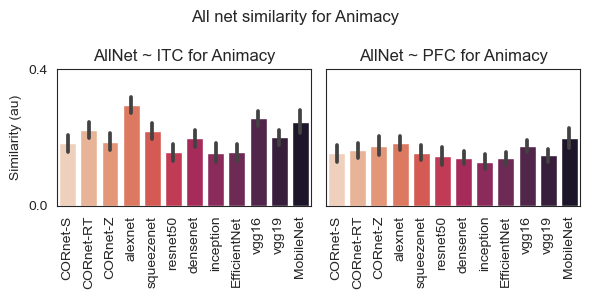

In [76]:
fig_sz = np.array([2,1]) * 3
plt_ylim = [0,.4]

all_peaks_itc = np.array(itc).max(axis=2)
all_peaks_pfc = np.array(pfc).max(axis=2)
all_mdl_itc_df = pd.DataFrame(all_peaks_itc.T, columns=all_models)
all_mdl_pfc_df = pd.DataFrame(all_peaks_pfc.T, columns=all_models)

sns.set_style('white')
fig1, axs = plt.subplots(figsize=fig_sz, nrows=1, ncols=2, sharey=True)

sim_bar_itc = sns.barplot(data=all_mdl_itc_df, palette='rocket_r', errorbar='sd', ax=axs[0])
sim_bar_itc.set_xticklabels(sim_bar_itc.get_xticklabels(), rotation=90)
axs[0].set_title(f'AllNet ~ ITC for {myCond}')
axs[0].set_ylabel('Similarity (au)')
axs[0].set_ylim(plt_ylim)
axs[0].set_yticks(plt_ylim)

sim_bar_pfc = sns.barplot(data=all_mdl_pfc_df, palette='rocket_r', errorbar='sd', ax=axs[1])
sim_bar_pfc.set_xticklabels(sim_bar_pfc.get_xticklabels(), rotation=90)
axs[1].set_title(f'AllNet ~ PFC for {myCond}')
axs[1].set_ylabel('')
# axs[0].set_ylim(plt_ylim)
# axs[0].set_yticks(plt_ylim)

plt.suptitle(f'All net similarity for {myCond}')
plt.tight_layout()

highest_sim_idx_itc = all_mdl_itc_df.mean(axis=0).argmax()
print(f'Highest similarity to ITC for {myCond}: {all_mdl_itc_df.columns[highest_sim_idx_itc].capitalize()} = {all_mdl_itc_df.mean(axis=0)[highest_sim_idx_itc].round(2)} -+ {all_mdl_itc_df.std(axis=0)[highest_sim_idx_itc].round(2)}')

highest_sim_idx_pfc = all_mdl_pfc_df.mean(axis=0).argmax()
print(f'Highest similarity to PFC for {myCond}: {all_mdl_pfc_df.columns[highest_sim_idx_pfc].capitalize()} = {all_mdl_pfc_df.mean(axis=0)[highest_sim_idx_pfc].round(2)} -+ {all_mdl_pfc_df.std(axis=0)[highest_sim_idx_pfc].round(2)}')

# plt.savefig(f'{FigDir}allnet_toBrain_sim_{myCond}.svg')